## Imports

In [ ]:
# !rm -rf glo-flow

In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 423 (delta 251), reused 302 (delta 135), pack-reused 0
Receiving objects: 100% (423/423), 970.53 KiB | 14.70 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [ ]:
import sys
sys.path.append('glo-flow/')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 'glo-flow/']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q comet_ml

     |████████████████████████████████| 315 kB 5.2 MB/s 
     |████████████████████████████████| 418 kB 59.4 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 


In [ ]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.notebook import tqdm
import os

BW_METHOD = 0.1
N_COMPONENTS = 32

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Dataset

In [ ]:
from modules.dataset import IdxDataset

In [ ]:
dataset_train = IdxDataset(MNIST(root='datasets', train=True, transform=transforms.ToTensor(), download=True))
subset_idx = torch.randint(low=0, high=len(dataset_train), size=(5_000, ))
subset = torch.utils.data.Subset(dataset_train, subset_idx)

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=False)
subset_loader = DataLoader(subset, batch_size=64, shuffle=False)
len(dataset_train), len(subset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



(60000, 5000)

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([64, 1, 28, 28])

## Generator

In [ ]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         latent_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sample_generator, sparse=True).to(device)

## FID Loss

In [ ]:
from modules.loss import ValLoss

In [ ]:
val_loss = ValLoss(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

## Training pipeline

In [ ]:
from modules.train_generator import GLOTrainer
from modules.loss import LapLoss

In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-mnist',
                        workspace='alexandernevarko',
                        log_code=True,
                        auto_metric_logging=False)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-mnist/06afb5789af740f49c8091ef140dce00



In [ ]:
trainer = GLOTrainer(model, logger=experiment)

In [ ]:
zlr = 1e-3
gen_lr = 1e-3
loss_func = LapLoss(max_levels=2, channels=1, device=device)
g_optimizer = torch.optim.Adam(params=model.generator.parameters(), lr=gen_lr)
z_optimizer = torch.optim.SparseAdam(params=model.z.parameters(), lr=zlr)
g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=100, gamma=0.2)
z_scheduler = torch.optim.lr_scheduler.StepLR(z_optimizer, step_size=130, gamma=0.2)

In [ ]:
n_epochs = 150
exp_name = f'SOTA_FID_Adam_SparseAdam_z_{N_COMPONENTS}_zlr_1e-3_glr_1e-3_{n_epochs}_epochs_strategy_1'
trainer.train(n_epochs=n_epochs, train_loader=train_loader, loss_func=loss_func, 
              generator_optimizer=g_optimizer, z_optimizer=z_optimizer,
              z_scheduler=z_scheduler, generator_scheduler=g_scheduler,
              fid_loader=train_loader, fid_loss=val_loss,
              exp_name=exp_name, model_path='/content/drive/MyDrive/GLANN/glo_mnist_models')

  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 0


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 0 loss: 0.0598595252534601


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 1 loss: 0.0385643252606458


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 2 loss: 0.035145754119687116


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 3 loss: 0.03268527732228737


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 4 loss: 0.03075746966919093


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 5 loss: 0.029289185309778653


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 6 loss: 0.028044351362692777


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 7 loss: 0.027111960324778486


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 8 loss: 0.026281323929283538


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 9 loss: 0.025569903064590654


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 10 loss: 0.024919064099918297


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 11 loss: 0.02435713754033547


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 12 loss: 0.023855224716415536


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 13 loss: 0.02336181576715222


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 14 loss: 0.022917766709809998


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 15


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 15 loss: 0.02254390405185187


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 16 loss: 0.022159606333512234


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 17 loss: 0.02181978167882606


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 18 loss: 0.02152455569322366


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 19 loss: 0.021258626444968207


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 20 loss: 0.020962990024117136


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 21 loss: 0.02071857955584775


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 22 loss: 0.020467161617950716


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 23 loss: 0.020230549824501533


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 24 loss: 0.0200296042363908


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 25


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 25 loss: 0.019839924692646907


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 26 loss: 0.019680565479261152


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 27 loss: 0.01948095115620508


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 28 loss: 0.01932103704534042


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 29 loss: 0.019165321124165552


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 30


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 30 loss: 0.019037357926654664


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 31 loss: 0.018872621401683734


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 32 loss: 0.018736719282896025


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 33 loss: 0.018608338128068426


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 34 loss: 0.01848818263463946


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 35


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 35 loss: 0.018411812831216783


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 36 loss: 0.018268922258462352


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 37 loss: 0.018169374665868942


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 38 loss: 0.01807410492281765


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 39 loss: 0.01794768281793321


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 40


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 40 loss: 0.017867373762282927


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 41 loss: 0.017785045728365433


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 42 loss: 0.017686826569129472


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 43 loss: 0.017619978652389318


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 44 loss: 0.017545288565681813


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 45


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 45 loss: 0.017457602172295677


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 46 loss: 0.0173981102235091


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 47 loss: 0.01732121841775488


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 48 loss: 0.017254452554703648


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 49 loss: 0.01718133432405399


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 50


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 50 loss: 0.017127843607447422


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 51 loss: 0.017076145182413332


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 52 loss: 0.01700833941132688


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 53 loss: 0.016938413107104457


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 54 loss: 0.016885917294206524


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 55


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 55 loss: 0.01684453193026819


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 56 loss: 0.016777907825831665


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 57 loss: 0.01673582754433473


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 58 loss: 0.016692208064628688


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 59 loss: 0.016636978904369163


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 60


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 60 loss: 0.016597185859770408


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 61 loss: 0.01652990047063337


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 62 loss: 0.01650787109552797


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 63 loss: 0.01645762206557622


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 64 loss: 0.016407791978872217


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 65


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 65 loss: 0.016386556139251572


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 66 loss: 0.01633266995607345


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 67 loss: 0.01629370423073549


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 68 loss: 0.016265527337297067


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 69 loss: 0.016219952169543646


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 70


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 70 loss: 0.016186412692919913


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 71 loss: 0.016144834286066643


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 72 loss: 0.01612292715350289


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 73 loss: 0.016073076756420866


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 74 loss: 0.016041386173541613


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 75


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 75 loss: 0.016016803856597525


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 76 loss: 0.01598858216833045


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 77 loss: 0.01595341700262257


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 78 loss: 0.01593207853184993


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 79 loss: 0.015884646397234917


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 80


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 80 loss: 0.015862347183824538


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 81 loss: 0.015843807032574087


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 82 loss: 0.01579998298657379


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 83 loss: 0.015781474533055954


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 84 loss: 0.015753508052989237


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 85


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 85 loss: 0.01572299953093375


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 86 loss: 0.015705099162548336


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 87 loss: 0.015656739032503638


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 88 loss: 0.01564060675619698


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 89 loss: 0.015618991719356287


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 90


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 90 loss: 0.015586658893252359


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 91 loss: 0.015561651999452539


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 92 loss: 0.015558532397471257


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 93 loss: 0.015513209102830208


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 94 loss: 0.015515730420409489


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 95


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 95 loss: 0.01547174661585104


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 96 loss: 0.01544647124597926


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 97 loss: 0.01543984514897439


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 98 loss: 0.0154209298157155


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 99 loss: 0.015402549572948263


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 100


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 100 loss: 0.014873463081628846


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 101 loss: 0.01479887446440232


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 102 loss: 0.01473350772288626


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 103 loss: 0.014676192472539921


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 104 loss: 0.014629762527395857


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 105


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 105 loss: 0.01458984046979849


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 106 loss: 0.014564616229337479


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 107 loss: 0.01454389768777721


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 108 loss: 0.014516915341636646


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 109 loss: 0.014493691320938152


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 110


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 110 loss: 0.014459533382580478


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 111 loss: 0.014442862265669843


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 112 loss: 0.014422152765285867


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 113 loss: 0.014402452130506097


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 114 loss: 0.014383190502124681


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 115


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 115 loss: 0.014363547589486913


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 116 loss: 0.014344461120244092


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 117 loss: 0.01433128074530377


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 118 loss: 0.014319867274956282


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 119 loss: 0.014299449935825522


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 120


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 120 loss: 0.014287362904794244


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 121 loss: 0.014269921909779437


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 122 loss: 0.014259096961825896


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 123 loss: 0.014246626685597875


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 124 loss: 0.014230294614784054


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 125


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 125 loss: 0.014223506036740758


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 126 loss: 0.014205927407539794


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 127 loss: 0.014198936661010358


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 128 loss: 0.014180861968499447


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 129 loss: 0.014172115651116188


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 130


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 130 loss: 0.014164558414226846


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 131 loss: 0.01414464523733806


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 132 loss: 0.014118869518881033


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 133 loss: 0.014098897127549786


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 134 loss: 0.01407116693136757


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 135


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 135 loss: 0.014032200435553787


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 136 loss: 0.014008774740823996


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 137 loss: 0.013993461058338059


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 138 loss: 0.013977772125334883


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 139 loss: 0.013971271328945786


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 140


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 140 loss: 0.013970875951733543


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 141 loss: 0.013957593926607864


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 142 loss: 0.013960917521990947


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 143 loss: 0.013956720218944079


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 144 loss: 0.013957358604825255


  0%|          | 0/938 [00:00<?, ?it/s]

Calculating FID and IS on epoch 145


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 145 loss: 0.013954797480652517


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 146 loss: 0.013944958722882116


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 147 loss: 0.013940484738592971


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 148 loss: 0.013935340401619228


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 149 loss: 0.013927293083529229


In [ ]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-mnist/06afb5789af740f49c8091ef140dce00
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [150] : (0.013927293083529229, 0.0598595252534601)
COMET INFO:     Average z-gradient [150]       : (0.00021102777100168169, 0.0003373052750248462)
COMET INFO:     FID on train [30]              : (15.700287066331251, 22.048565202188072)
COMET INFO:     IS on train [30]               : (2.4057695865631104, 2.4279122352600098)
COMET INFO:     Train loss [140700]            : (0.01065573189407587, 0.19641807675361633)
COMET INFO:   Others:
COMET INFO:     Name         : SOTA_FID_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_150_epochs_strategy_1
COMET IN

## Z-distribution

In [ ]:
z_numpy = model.z.weight.detach().cpu().numpy()

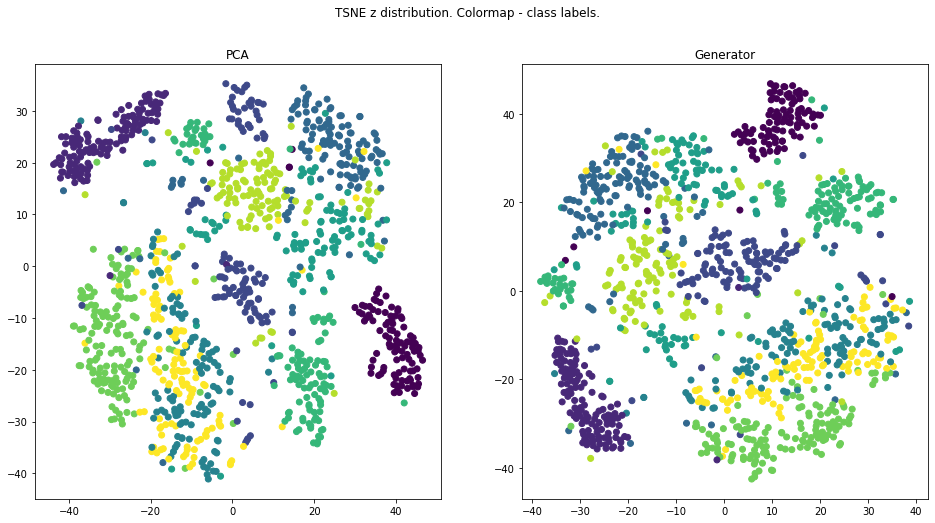

In [ ]:
# plt.figure(figsize=(8, 16))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('TSNE z distribution. Colormap - class labels.')

# PCA
z_pca = sample_generator.z_dataset[::50, :]
cmap = sample_generator.get_classes()[::50]
X_embedded = TSNE(n_components=2).fit_transform(z_pca)
ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
ax1.set_title('PCA')

# Generator learned dsitribution
z_model = model.z.weight.detach().cpu().numpy()[::50, :]
X_embedded = TSNE(n_components=2).fit_transform(z_model)
ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
ax2.set_title('Generator')

# fig.tight_layout()
plt.show()

## Calculate metrics

In [ ]:
fid, inception_score = val_loss(model, train_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
fid, inception_score

(15.61070534067159, 2.425729)

## Test results

In [ ]:
from modules.validate import Validator
from torchvision.utils import save_image

In [ ]:
dataset_test = IdxDataset(MNIST(root='datasets', train=False, transform=transforms.ToTensor(), download=True))
test_subset_idx = torch.randint(0, len(dataset_test), size=(96, ))
test_subset = torch.utils.data.Subset(dataset_test, test_subset_idx)

test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)
test_subset_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
len(dataset_test), len(test_subset)

(10000, 96)

In [ ]:
# generator = GLOGenerator(min_channels=16,
#                          max_channels=128,
#                          latent_channels=N_COMPONENTS,
#                          num_blocks=3,
#                          dataloader=train_loader,
#                          normalization='ada',
#                          lrelu_slope=0).to(device)
# sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
# model = GLOModel(generator, sample_generator, sparse=True).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/glo_mnist_models/SOTA_FID_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_150_epochs_strategy_1_model.pth'))
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
sampler = SampleGenerator(sampler_init_test_loader, N_COMPONENTS, BW_METHOD)

In [ ]:
model.eval()
z = nn.Embedding.from_pretrained(sampler.get_z_dataset(),
                                 max_norm=1, sparse=True, freeze=False).to(device)
z.requires_grad_(True)
optimizer = torch.optim.SparseAdam(z.parameters(), lr=1e-2)
loss_func = LapLoss(max_levels=2, channels=1, device=device)

validator = Validator(model, test_subset_loader)

In [ ]:
z_new, loss = validator.validate(z=z, min_loss=0.02, max_iter=250, loss_func=loss_func, optimizer=optimizer)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print('Average validation loss:', loss)

Average validation loss: 0.01981197918454806


  0%|          | 0/3 [00:00<?, ?it/s]

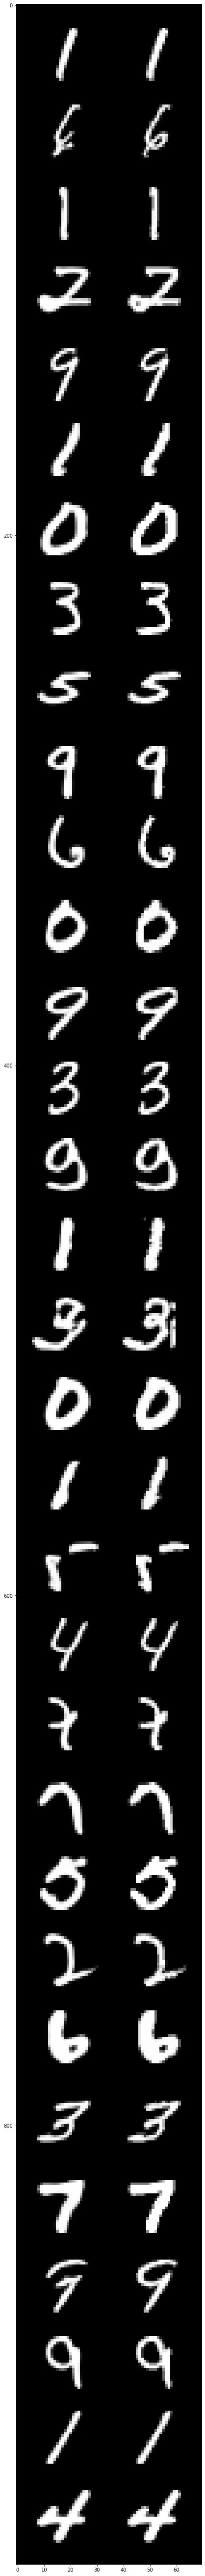

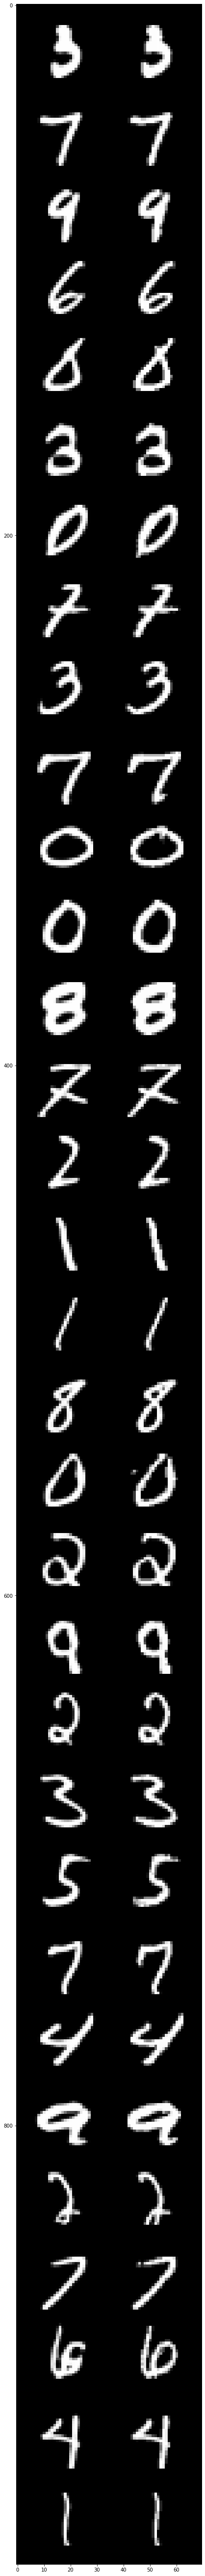

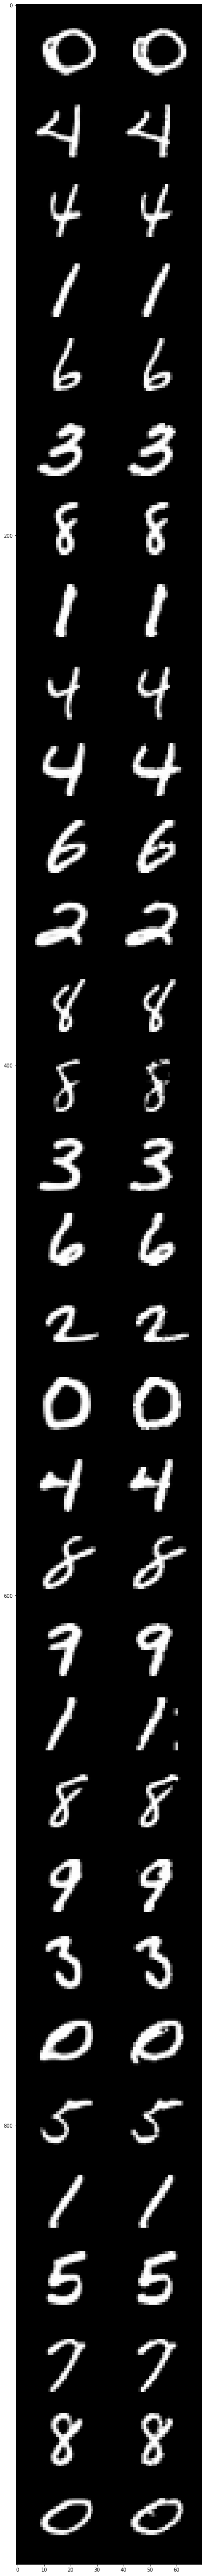

In [ ]:
model.eval()
max_batches = 3
img_size = 32
img_save_path = ''
for i, (idx, img, target) in enumerate(tqdm(test_subset_loader)):
    if i >= max_batches:
        break
    idx = idx.long().to(device)
    z_batch = z(idx)
    save_file = os.path.join(img_save_path, f'val_img_{i}.png')
    res = validator.visualize_val_results(z=z_batch, img=img, save_file=save_file)
    plt.figure(figsize=(img_size, 3*img_size))
    plt.imshow(res)

### Manual testing

In [ ]:
to_pil = transforms.ToPILImage()

In [ ]:
idx = torch.tensor([1], dtype=torch.int64).to(device)
fixed_latent = model.z(idx)

In [ ]:
# Find the closest vector
latents = model.z.weight
distance_vectors = latents - fixed_latent
norms = torch.sum(distance_vectors ** 2, dim=1)

In [ ]:
argsort = torch.argsort(norms)
argsort[[0, 1, 2]]

tensor([    1, 36953, 45857], device='cuda:0')

In [ ]:
close_idx = torch.tensor(argsort[[4, 25]], dtype=torch.int64).to(device)

mix_inputs = torch.sum(model.z(close_idx), dim=0) / len(close_idx)
mix_inputs = mix_inputs.unsqueeze(0).to(device)

trained_res = model(idx=close_idx).to('cpu')
mixed_res = model(inputs=mix_inputs).to('cpu')

0


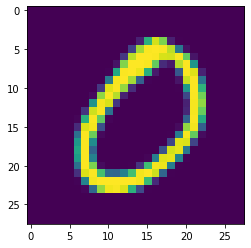

1


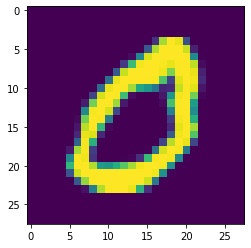

In [ ]:
for i, img in enumerate(trained_res):
    print(i)
    plt.imshow(to_pil(img))
    plt.show()

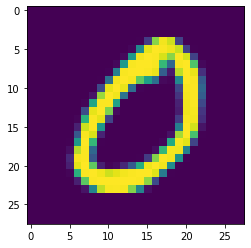

In [ ]:
plt.imshow(to_pil(mixed_res[0]))